# Modelos Long-Short Term Memory 

Laboratorio 02 – Series de Tiempo con Deep Learning

Edwin Ortega 22305 - Esteban Zambrano 22119 - Diego García 22404

Para este laboratorio trabajaremos con las series Regular_Imp y Diesel_Con ya que ambas series fueron completamente modeladas y analizadas en el laboratorio 1 además de su disponibilidad de datos adecuados para LSTM.

### Librerías necesarias

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
# pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math

### Preprocesamiento

##### Cargar el dataset correctamente

In [6]:
df = pd.read_csv("../data/clean/Series_de_Tiempo_Combustibles.csv", parse_dates=["fecha"])
df = df.sort_values("fecha")
df.set_index("fecha", inplace=True)
df.head()

,Regular_Imp,Superior_Imp,Diesel_Imp,Regular_Con,Superior_Con,Diesel_Con
fecha,,,,,,
2000-01-01,NaN,NaN,NaN,202645.20,308156.82,634667.06
2000-02-01,NaN,NaN,NaN,205530.96,307766.31,642380.66
2000-03-01,NaN,NaN,NaN,229499.56,331910.29,699807.25
2000-04-01,NaN,NaN,NaN,210680.40,315648.08,586803.98
2000-05-01,NaN,NaN,NaN,208164.34,319667.97,656948.20


##### Visualización Exploratoria de las Series Temporales

Se grafican las series originales de importación y consumo de combustibles sin aplicar aún ningún filtro o limpieza. Esto para poder identificar tendencias, patrones y posibles problemas en los datos (como valores nulos o ceros).

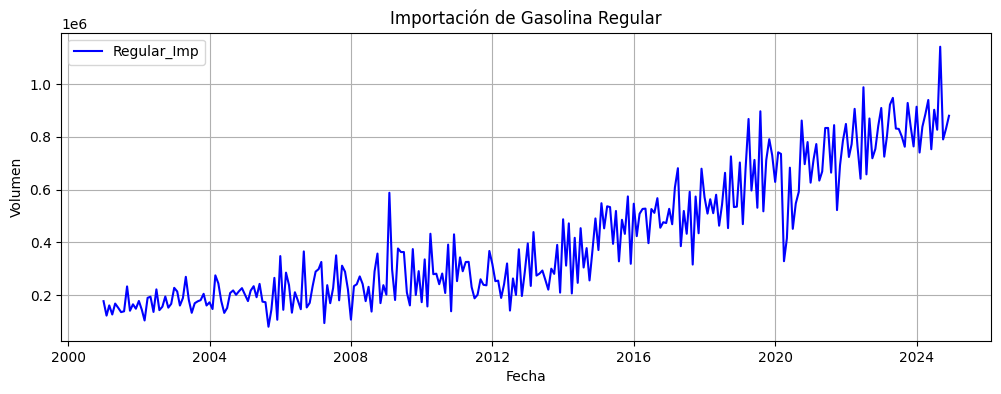

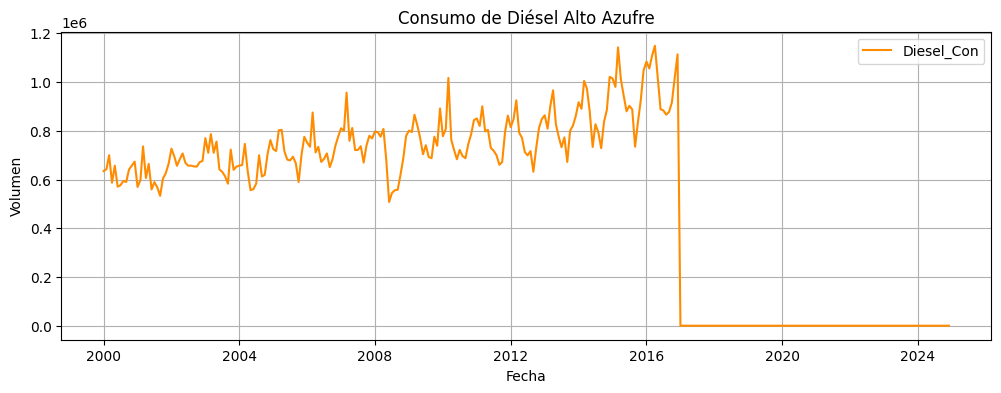

In [4]:
# Series seleccionadas
regular_imp = df["Regular_Imp"].dropna()
diesel_con = df["Diesel_Con"].dropna()

# Graficar Regular_Imp
plt.figure(figsize=(12, 4))
plt.plot(regular_imp, label="Regular_Imp", color='blue')
plt.title("Importación de Gasolina Regular")
plt.xlabel("Fecha")
plt.ylabel("Volumen")
plt.grid()
plt.legend()
plt.show()

# Graficar Diesel_Con
plt.figure(figsize=(12, 4))
plt.plot(diesel_con, label="Diesel_Con", color='darkorange')
plt.title("Consumo de Diésel Alto Azufre")
plt.xlabel("Fecha")
plt.ylabel("Volumen")
plt.grid()
plt.legend()
plt.show()


**Observaciones:**
- La serie `Regular_Imp` muestra una tendencia creciente constante, ideal para modelado con LSTM.
- La serie `Diesel_Con` se interrumpe drásticamente en 2017, a partir de esa fecha todos los valores son cero.

##### Preprocesamiento de Datos para Modelado LSTM

Se seleccionan y limpian las series relevantes para el modelado. En el caso de `Diesel_Con`, se recorta hasta 2017 para evitar valores nulos o ceros que afecten el entrenamiento. También se eliminan valores nulos en `Regular_Imp`.

In [ ]:
# Filtrar Diesel_Con eliminando los ceros finales
diesel_con = diesel_con[diesel_con > 0]

# Escalar ambas series
scaler_reg = MinMaxScaler()
scaler_diesel = MinMaxScaler()

regular_scaled = scaler_reg.fit_transform(regular_imp.values.reshape(-1, 1))
diesel_scaled = scaler_diesel.fit_transform(diesel_con.values.reshape(-1, 1))

# Separar 80% entrenamiento y 20% prueba
def split_data(series_scaled, train_ratio=0.8):
    n = len(series_scaled)
    train_size = int(n * train_ratio)
    return series_scaled[:train_size], series_scaled[train_size:]

train_reg, test_reg = split_data(regular_scaled)
train_diesel, test_diesel = split_data(diesel_scaled)

# Función para crear secuencias LSTM
def create_sequences(data, window_size=12):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 12  # 12 meses (1 año)

X_reg, y_reg = create_sequences(train_reg, window_size)
X_reg_test, y_reg_test = create_sequences(test_reg, window_size)

X_diesel, y_diesel = create_sequences(train_diesel, window_size)
X_diesel_test, y_diesel_test = create_sequences(test_diesel, window_size)

# Confirmar formas
print("Regular:", X_reg.shape, y_reg.shape)
print("Diesel:", X_diesel.shape, y_diesel.shape)


Regular: (218, 12, 1) (218, 1)
Diesel: (151, 12, 1) (151, 1)
